<a href="https://colab.research.google.com/github/ejlee127/sound-learning/blob/main/train_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
# Find the latest version of spark 3.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
spark_version = 'spark-3.0.1'
#spark_version = 'spark-3.<enter version>'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]


In [2]:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar

--2020-11-13 23:14:37--  https://jdbc.postgresql.org/download/postgresql-42.2.9.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914037 (893K) [application/java-archive]
Saving to: ‘postgresql-42.2.9.jar’

postgresql-42.2.9.j 100%[===================>] 892.61K  5.01MB/s    in 0.2s    

2020-11-13 23:14:38 (5.01 MB/s) - ‘postgresql-42.2.9.jar’ saved [914037/914037]



UrbanSound Machine Learning: Experiment 1


*   Inputs: MFCCs avg values


> input tables : fold1_mfcc_avg_n_40.csv  ~  fold10_mfcc_avg_n_40.csv

> mfcc : MFCC feature

> avg : mean

> n_40 : each sample is an array of length 40

*   Model : keras-Sequential

> run through various parameters, defined below



In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()

In [4]:
import numpy as np
import pandas as pd
import json

import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [29]:
# Define functions

# create_train_test_val_set():
#   returns train set of [X, y], test set of [X, y] and val set of [X, y]
#   tables : list of mfcc_avg_n_40 tables
#   test_index : folders for test
#   val_index : for for validation
def create_train_test_val_set(tables, test_index, val_index):

  #train_list = [ i for i in range(1,NUMFOLDS+1) if i not in TESTFOLD ]
  train_df = pd.DataFrame({})
  test_df = pd.DataFrame({})
  val_df = pd.DataFrame({})

  for i in range(1,NUMFOLDS+1):
    # load the table of fold{i}
    df_pandas = tables[i-1].toPandas()

    if i in test_index:      
      test_df = pd.concat( [test_df, df_pandas] )
    elif i in val_index:
      val_df = pd.concat( [val_df, df_pandas] )
    else:
      train_df = pd.concat( [train_df, df_pandas] )

  X_train = train_df.drop(['fileID', 'classID'], axis = 1)
  y_train = train_df['classID']
  train_Xy = [X_train.astype('float32'), y_train.astype('int')]

  X_test = test_df.drop(['fileID', 'classID'], axis = 1)
  y_test = test_df['classID']
  test_Xy = [X_test.astype('float32'), y_test.astype('int')]

  X_val = val_df.drop(['fileID', 'classID'], axis = 1)
  y_val = val_df['classID']
  val_Xy = [X_val.astype('float32'), y_val.astype('int')]

  print("X_train shape: ", X_train.shape)
  print("y_train shape: ", y_train.shape)
  print("X_test shape: ", X_test.shape)
  print("y_test shape: ", y_test.shape)
  print("X_val shape: ", X_val.shape)
  print("y_val shape: ", y_val.shape)

  return train_Xy, test_Xy, val_Xy


#-----------------------------
# Define the parameters for the model training and classification report
class_names=["air_conditioner",
             "car_horn",
             "children_playing",
             "dog_bark",
             "drilling",
             "engine_idling",
             "gun_shot",
             "jackhammer",
             "siren",
             "street_music"]

# Set the parameters for Sequential model
numClasses = 10 # number of target neurons
neuronsHidden = [2**6, 2**7, 2**8, 2**9]
dropouts = [0.3, 0.4, 0.5]
epochs = [30, 40, 50]
batchsizes = [16, 32]

#- for test, set a little bit
#neuronsHidden = [2**6]
#dropouts = [0.3]
#epochs = [30]
#batchsizes = [16,32]
#-----------------------------

# train_Model_save_Result:
#    run Sequential model for the set of parameters, and save the result in a file
def train_Model_save_Result(resultfile, X_train, y_train, X_test, y_test, X_val, y_val, scaled=True):


  #{"parameters": ['nb_neurons', 'dropout', 'nb_epoch', 'batch_size'],
  # "report" : classification_report, ...


  # Scaling - transform
  if scaled:
    print("inputs are scaled.")
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.fit_transform(X_test)
    X_val = ss.fit_transform(X_val)

  param_results = []
  optimizer = keras.optimizers.Adam(learning_rate=0.0001)

  for nn in neuronsHidden:
    for dd in dropouts:
      for ee in epochs:
        for bb in batchsizes:
          print(f"nb_neurons={nn}, dropout={dd}, nb_epoch={ee}, batch_size={bb}")
          
          # Set the model
          model = Sequential()
          model.add(Dense(nn))
          model.add(Activation('relu'))
          model.add(Dropout(dd))
          model.add(Dense(nn))
          model.add(Activation('relu'))
          model.add(Dropout(dd))
          model.add(Dense(numClasses))
          model.add(Activation('softmax'))

          # Complile model
          model.compile(optimizer=optimizer,
             loss = "sparse_categorical_crossentropy",
             metrics=["accuracy"])          

          # Train
          model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=ee, batch_size=bb, verbose=0)

          # Predict with X-test
          predictions = np.argmax(model.predict(X_test), axis=1)

          # predictions = np.argmax(model.predict(X_test), axis=1)
          report = classification_report(y_test, predictions,
                                  target_names=class_names,
                                  output_dict=True)
          
          print(f"parameters:({nn,dd,ee,bb}):",report["accuracy"])

          result_dict = {
              "parameters" : [nn,dd,ee,bb],
              "report" : report,
              "finalAcc" : model_history.history["accuracy"][-1],
              "finalVal" : model_history.history["val_accuracy"][-1],
              "finalAccData" : model_history.history["accuracy"],
              "finalValData" : model_history.history["val_accuracy"]
          }
          param_results.append(result_dict)

          # clearing the model
          keras.backend.clear_session()

  with open(resultfile, "w") as f:
    json.dump(param_results, f)

In [7]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#### Test google drive ########
test_dict = {"parameters" : [1,1,1,1]}
with open("/content/drive/My Drive/BootCamp/Project3-UrbanSound/test.json", "w") as f:
   json.dump(test_dict, f)
#### test ####################

In [8]:
# Set the file path
myproject_path = "/content/drive/My Drive/BootCamp/Project3-UrbanSound/"
dataset_path = os.path.join(myproject_path, "datasets/sql_tables/mfcc_avg_n_40_tables/")
output_path = os.path.join(myproject_path, "exp1_results/")

# Set the folders to test and validate, remaining will be in train set.
NUMFOLDS = 10

# Read mfcc_avg_n_40 tables from csv files
list_tables = []
for i in range(1,NUMFOLDS+1):
  fn = f"fold{i}_mfcc_avg_n_40.csv"
  filepath = os.path.join(dataset_path,fn)
  table = spark.read.option("header", "true").csv(filepath)
  list_tables.append(table)

list_tables[3].show()


+------+-------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+------------------+--------------------+-------------------+-------------------+--------------------+--------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-------------------+-------------------+------------------+--------------------+--------------------+-------------------+-------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+-------------------+
|fileID|classID|         mfcc_avg_0|        mfcc_avg_1|         mfcc_avg_2|         mfcc_avg_3|         mfcc_avg_4|         mfcc_avg_5|         mfcc_avg_6|         mfcc_avg

In [ ]:
# Set the folders to train and test (cross-validation)
#list_test_folds = [ [1, 2], [4, 5], [7, 8], [10, 1] ]
#list_val_folds = [ [3], [6], [9], [2] ]
list_test_folds = [ [10, 1] ]
list_val_folds = [ [2] ]

# Train model and save the results
for i in range(len(list_test_folds)):
  test_idx = list_test_folds[i]
  val_idx = list_val_folds[i]
  train_Xy, test_Xy, val_Xy = create_train_test_val_set(list_tables, test_idx, val_idx)
  resultfile = os.path.join(output_path, f"exp1FinalResults-{test_idx[0]}{test_idx[1]}{val_idx[0]}_scaled.json")
  print(resultfile)
  train_Model_save_Result(resultfile, train_Xy[0], train_Xy[1], test_Xy[0], test_Xy[1], val_Xy[0], val_Xy[1], scaled=True)


X_train shape:  (6134, 40)
y_train shape:  (6134,)
X_test shape:  (1710, 40)
y_test shape:  (1710,)
/content/drive/My Drive/BootCamp/Project3-UrbanSound/exp1_results/exp1FinalResults-1012_scaled.json
inputs are scaled.
nb_neurons=64, dropout=0.3, nb_epoch=30, batch_size=16
parameters:((64, 0.3, 30, 16)): 0.47251461988304094
nb_neurons=64, dropout=0.3, nb_epoch=30, batch_size=32
parameters:((64, 0.3, 30, 32)): 0.4777777777777778
nb_neurons=64, dropout=0.3, nb_epoch=40, batch_size=16
parameters:((64, 0.3, 40, 16)): 0.48830409356725146
nb_neurons=64, dropout=0.3, nb_epoch=40, batch_size=32
parameters:((64, 0.3, 40, 32)): 0.4964912280701754
nb_neurons=64, dropout=0.3, nb_epoch=50, batch_size=16
parameters:((64, 0.3, 50, 16)): 0.5
nb_neurons=64, dropout=0.3, nb_epoch=50, batch_size=32
parameters:((64, 0.3, 50, 32)): 0.4847953216374269
nb_neurons=64, dropout=0.4, nb_epoch=30, batch_size=16
parameters:((64, 0.4, 30, 16)): 0.47309941520467835
nb_neurons=64, dropout=0.4, nb_epoch=30, batch_size

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


parameters:((64, 0.5, 30, 16)): 0.4543859649122807
nb_neurons=64, dropout=0.5, nb_epoch=30, batch_size=32
parameters:((64, 0.5, 30, 32)): 0.4801169590643275
nb_neurons=64, dropout=0.5, nb_epoch=40, batch_size=16
parameters:((64, 0.5, 40, 16)): 0.47543859649122805
nb_neurons=64, dropout=0.5, nb_epoch=40, batch_size=32
parameters:((64, 0.5, 40, 32)): 0.47485380116959064
nb_neurons=64, dropout=0.5, nb_epoch=50, batch_size=16
parameters:((64, 0.5, 50, 16)): 0.5017543859649123
nb_neurons=64, dropout=0.5, nb_epoch=50, batch_size=32
parameters:((64, 0.5, 50, 32)): 0.47485380116959064
nb_neurons=128, dropout=0.3, nb_epoch=30, batch_size=16
parameters:((128, 0.3, 30, 16)): 0.49298245614035086
nb_neurons=128, dropout=0.3, nb_epoch=30, batch_size=32
parameters:((128, 0.3, 30, 32)): 0.5035087719298246
nb_neurons=128, dropout=0.3, nb_epoch=40, batch_size=16
parameters:((128, 0.3, 40, 16)): 0.531578947368421
nb_neurons=128, dropout=0.3, nb_epoch=40, batch_size=32
parameters:((128, 0.3, 40, 32)): 0.5

Experiment 1: best model instance = 71
> Best model parameter [512, 0.5, 50, 32]

In [30]:

numClasses=10
nn=512 # number of neurons
dd=0.5 # dropout
ee=50 # epoch
bb=32 # batch_size

model_file = os.path.join(output_path, f"exp1BestModel_trained.h5")
          

#list_test_folds = [ [1, 2], [4, 5], [7, 8], [10, 1] ]
#list_val_folds = [ [3], [6], [9], [2] ]
list_test_folds = [ [7, 8] ]
list_val_folds = [ [9] ]

accuracy = 0
best_idx = 0
model_history_array = []
model_report_array = []
for i in range(len(list_test_folds)):
  test_idx = list_test_folds[i]
  val_idx = list_val_folds[i]
  train_Xy, test_Xy, val_Xy = create_train_test_val_set(list_tables, test_idx, val_idx)

  ss = StandardScaler()
  X_train = ss.fit_transform(train_Xy[0])
  y_train = train_Xy[1]
  X_test = ss.fit_transform(test_Xy[0])
  y_test = test_Xy[1]
  X_val = ss.fit_transform(val_Xy[0])
  y_val = val_Xy[1]

  # Set the model
  optimizer = keras.optimizers.Adam(learning_rate=0.0001)
  model = Sequential()
  model.add(Dense(nn))
  model.add(Activation('relu'))
  model.add(Dropout(dd))
  model.add(Dense(nn))
  model.add(Activation('relu'))
  model.add(Dropout(dd))
  model.add(Dense(numClasses))
  model.add(Activation('softmax'))

  # Complile model
  model.compile(optimizer=optimizer,
  loss = "sparse_categorical_crossentropy",
  metrics=["accuracy"])

  # Train
  model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=ee, batch_size=bb, verbose=0)

  # Predict with X-test
  predictions = np.argmax(model.predict(X_test), axis=1)

  report = classification_report(y_test, predictions,
                                  target_names=class_names,
                                  output_dict=True)
  
  result_dict = {
              "parameters" : [nn,dd,ee,bb],
              "report" : report,
              "finalAcc" : model_history.history["accuracy"][-1],
              "finalVal" : model_history.history["val_accuracy"][-1],
              "finalAccData" : model_history.history["accuracy"],
              "finalValData" : model_history.history["val_accuracy"]
          }

  print(i, test_idx, report["accuracy"])
  model_history_array.append(model_history)
  model_report_array.append(result_dict)

  print(model.evaluate(X_test, y_test))

  if accuracy < report["accuracy"]:
    accuracy = report["accuracy"]
    best_idx = i
    print(i)
    model.save(model_file)

  #keras.backend.clear_session()

# Save the best model result
result_file = os.path.join(output_path, f"exp1BestModel_result_{list_test_folds[best_idx]}.json")
with open(result_file, "w") as f:
    json.dump(model_report_array[best_idx], f)

X_train shape:  (6272, 40)
y_train shape:  (6272,)
X_test shape:  (1644, 40)
y_test shape:  (1644,)
X_val shape:  (816, 40)
y_val shape:  (816,)
0 [7, 8] 0.5900243309002433
52/52 [==============================] - 0s 2ms/step - loss: 1.5306 - accuracy: 0.5900
[1.5305756330490112, 0.5900243520736694]
0


In [31]:
# Load the model
from tensorflow.keras.models import load_model

sound_model = load_model(model_file)
print(sound_model.evaluate(X_test, y_test))

52/52 [==============================] - 0s 2ms/step - loss: 1.5306 - accuracy: 0.0766
[1.5305756330490112, 0.07664233446121216]


In [13]:
import matplotlib.pyplot as plt

def plot_history(history):
  fig, axs = plt.subplots(2)

  #create the accuracy subplot
  axs[0].plot(history.history["accuracy"],label="train accuracy")
  axs[0].plot(history.history["val_accuracy"],label="test accuracy")
  axs[0].set_ylabel("Accuracy")
  axs[0].legend(loc="best")
  axs[0].set_title("accuracy eval")

  # create accuracy
  axs[1].plot(history.history["loss"],label="train error")
  axs[1].plot(history.history["val_loss"],label="test error")
  axs[1].set_ylabel("Error")
  axs[1].set_xlabel("Epoch")
  axs[1].legend(loc="best")
  axs[1].set_title("Error eval")

  plt.show()

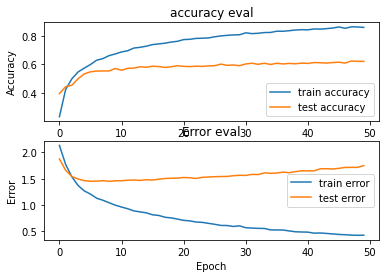

In [27]:

plot_history(model_history_array[0])
#plot_history(model_history_array[1])
#plot_history(model_history_array[2])
#plot_history(model_history_array[3])

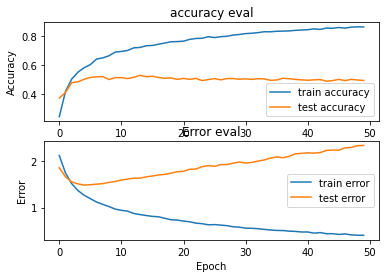

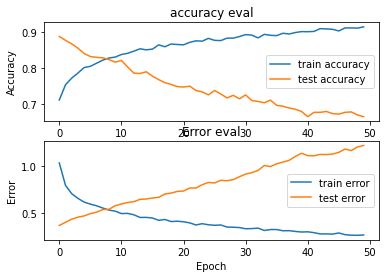

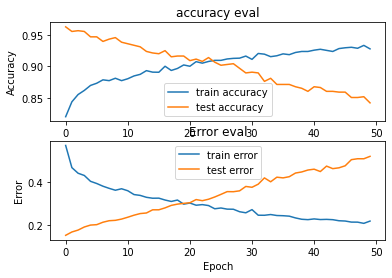

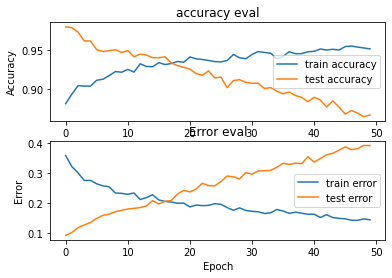

In [14]:
# When clearing and remodel setting are not done, what happens.
plot_history(model_history[0])
plot_history(model_history[1])
plot_history(model_history[2])
plot_history(model_history[3])

54/54 [==============================] - 0s 2ms/step - loss: 0.2420 - accuracy: 0.1187
[0.24197104573249817, 0.11871345341205597]
